## Fera Formidável 4.7

### Preciso de um espaço (latente) para pensar
#### Rômulo 24024

### Enunciado:
**Objetivo:** implemente uma rede neural do tipo autoencoder utilizando PyTorch ou lightning. Treine esta rede no conjunto de dados que desejar e comente sobre o que é o codificador, o que é o decodificador e o que é o espaço latente. Representações visuais são bem-vindas se possível.

**Comentário:** diversos exemplos usam datasets de imagens para mostrar como uma rede tipo autoencoder funciona. Quem sabe seja interessante se informar sobre camadas convolucionais caso opte por esta estratégia.

**Dificultando um pouco mais:** existem arquiteturas chamadas de autoencoder variacionais. São um pouco mais complicadas que as não-variacionais, porém são capazes de gerar novos dados. Veja se acha interessante abraçar este desafio adicional.

### Introdução:
Autoencoder é um modelo de rede neural não supervisionado que tem por objetivo representar os dados de entrada de uma forma de dimensionalidade reduzida, para que assim o modelo tome em consideração as informações mais importantes, e após isso decodificar de forma que os dados de saída sejam o mais próximo possível do original.

O autoencoder pode ser dividido em duas etapas:

- **Encoder:** A partir do encoder, recebemos os dados de entrada e realizamos redução de dimensionalidade. Podemos fazer isso através da diminuição de neurônios nas camadas ocultas. Assim, teremos uma diminuição no número de dados representativos no espaço latente (bottleneck). Para o sucesso do modelo, as camadas no espaço latente devem ter número de dados grande o suficiente para não perdermos informações e ao mesmo tempo reduzido o bastante para levarmos em consideração apenas as informações mais importantes.

- **Decoder:** A partir do decoder, pegaremos estes dados de dimensionalidade reduzida e transformaremos de volta nas dimensões originais. Haverá, portanto, o ajuste dos parâmetros para que, a partir dos dados mais importantes, possamos inferir os dados que foram dispensados no espaço latente, para que os dados tenham mesma dimensionalidade dos dados de entrada.

Imports necessários:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

torch.manual_seed(77) # Tornar resultados reprodutíveis

train_dataset = datasets.MNIST(root='./Datasets/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./Datasets/mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

loader_treino = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
loader_teste = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

100.0%
100.0%
100.0%
100.0%


Criando a classe do nosso modelo Autoencoder:

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, dimensao_original, dimensoes_bottle): # Recebemos como parâmetros o tamanho original dos dados e o tamanho dos dados no estado de bottleneck
        super().__init__()
        self.encoder = nn.Sequential( # Autoencoder, em que haverá a redução do tamanho dos dados na rede para o Espaço latente
            nn.Linear(dimensao_original, dimensoes_bottle), 
            nn.ReLU(),
            nn.Linear(dimensoes_bottle, int(dimensoes_bottle/2))  # Espaço latente
        )
        self.decoder = nn.Sequential( # Autoencoder, em que haverá a aumento do tamanho dos dados na rede a partir o Espaço latente
            nn.Linear(int(dimensoes_bottle/2), dimensoes_bottle),
            nn.ReLU(),
            nn.Linear(dimensoes_bottle, dimensao_original),
            nn.Sigmoid() # Sigmoide pois estamos trabalhando com imagens
        )

    def forward(self, x): # Definição da nossa função foward
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Agora vamos criar dois modelos, um com número de neurônios maior no Espaço Latente, outro menor:

In [3]:
modelo = Autoencoder(784, 140) # Nº maior (140)
modelo_bottle_reduzido = Autoencoder(784, 28) # Nº menor (28)

criterion = nn.MSELoss() # Nosso critério de perda
optimizer = optim.Adam(modelo.parameters(), lr=1e-3) # Otimizador para o 1º modelo
optimizer_bottle = optim.Adam(modelo_bottle_reduzido.parameters(), lr=1e-3) # Otimizador para o 2º modelo
# Ambos otimizadores são iguais, o que muda é a associação dos parâmetros de cada modelo

Vamos agora treinar o 1º modelo:

In [4]:
epochs = 10
train_loss = []

for epoch in range(epochs):
    modelo.train()
    epoch_loss = 0
    for imgs, _ in loader_treino:
        imgs = imgs.view(-1, 784)
        outputs = modelo(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    loss_medio = epoch_loss / len(loader_treino)
    train_loss.append(loss_medio)
    print(f"Época {epoch+1}/{epochs}, Perda: {loss_medio:.4f}")

Época 1/10, Perda: 0.0453
Época 2/10, Perda: 0.0177
Época 3/10, Perda: 0.0128
Época 4/10, Perda: 0.0104
Época 5/10, Perda: 0.0089
Época 6/10, Perda: 0.0079
Época 7/10, Perda: 0.0072
Época 8/10, Perda: 0.0066
Época 9/10, Perda: 0.0062
Época 10/10, Perda: 0.0058


Agora treinaremos o segundo:

In [5]:
epochs = 10
train_loss_ = []

for epoch in range(epochs):
    modelo_bottle_reduzido.train()
    epoch_loss = 0
    for imgs, _ in loader_treino:
        imgs = imgs.view(-1, 784)
        outputs = modelo_bottle_reduzido(imgs)
        loss = criterion(outputs, imgs)

        optimizer_bottle.zero_grad()
        loss.backward()
        optimizer_bottle.step()
        epoch_loss += loss.item()
    
    loss_medio = epoch_loss / len(loader_treino)
    train_loss_.append(loss_medio)
    print(f"Época {epoch+1}/{epochs}, Perda: {loss_medio:.4f}")

Época 1/10, Perda: 0.0709
Época 2/10, Perda: 0.0404
Época 3/10, Perda: 0.0338
Época 4/10, Perda: 0.0312
Época 5/10, Perda: 0.0294
Época 6/10, Perda: 0.0276
Época 7/10, Perda: 0.0263
Época 8/10, Perda: 0.0255
Época 9/10, Perda: 0.0251
Época 10/10, Perda: 0.0247


Vamos analisar as funções de perda:

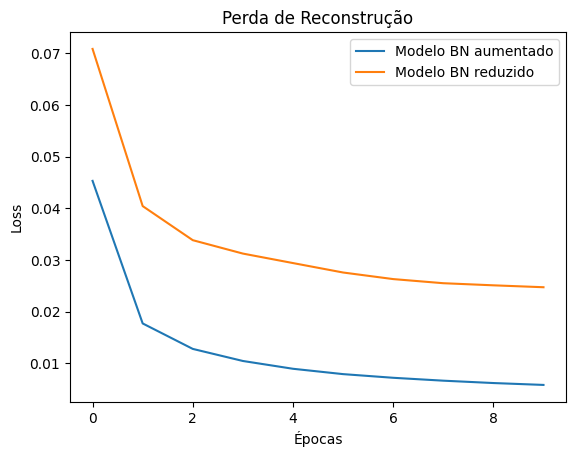

In [17]:
# Gráfico de perda
plt.plot(train_loss) 
plt.plot(train_loss_)
plt.legend(['Modelo BN aumentado','Modelo BN reduzido'])
plt.title("Perda de Reconstrução")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

Podemos observar que com o espaço latente reduzido, a perda é consideravelmente maior, pois mais dados são perdidos na compactação.

Agora vamos ver algumas comparções visuais:

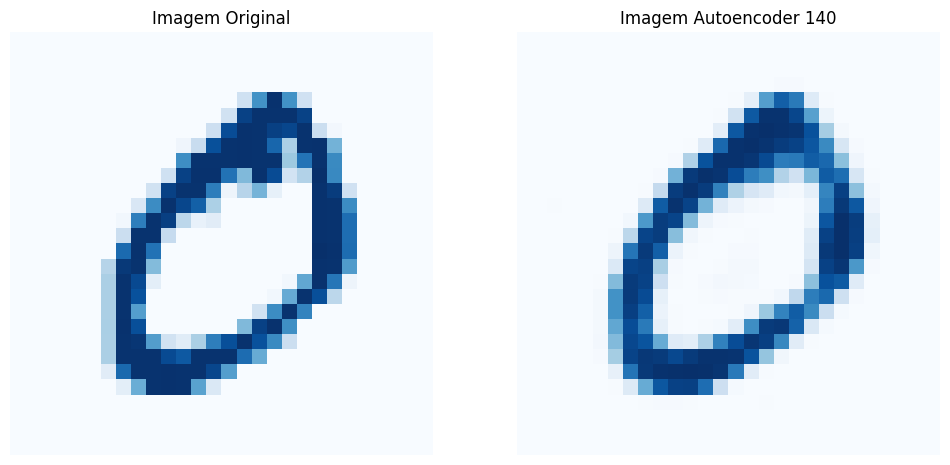

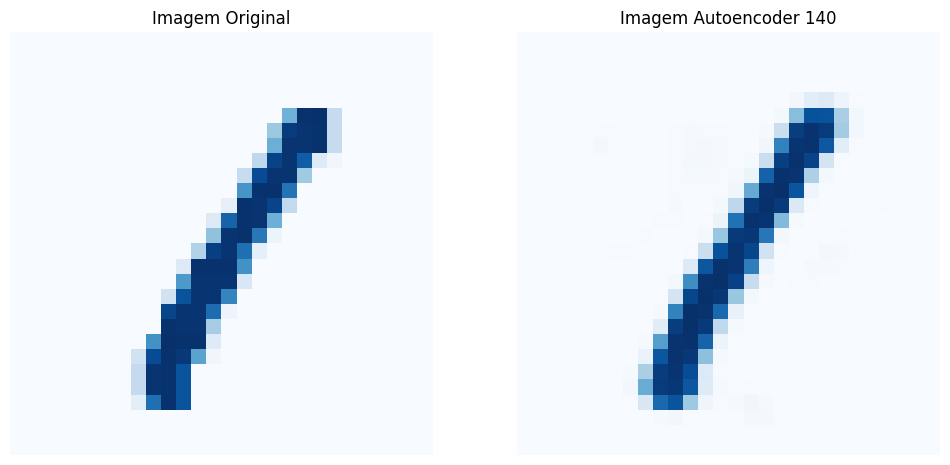

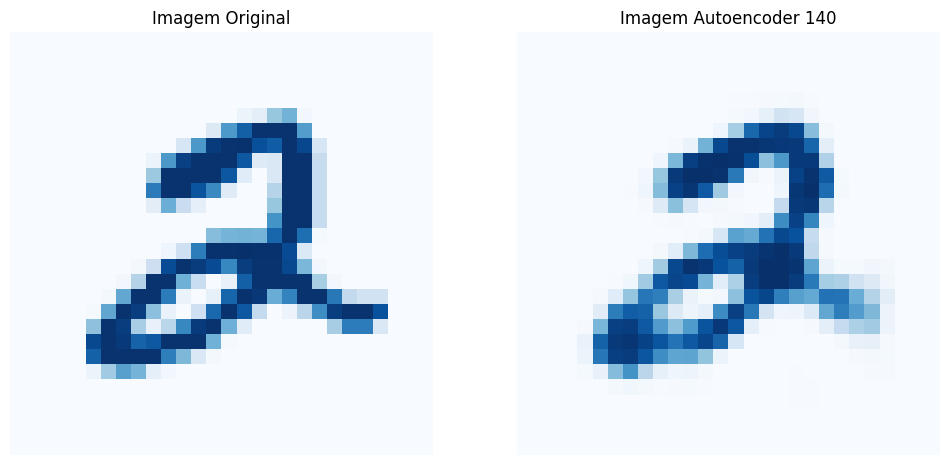

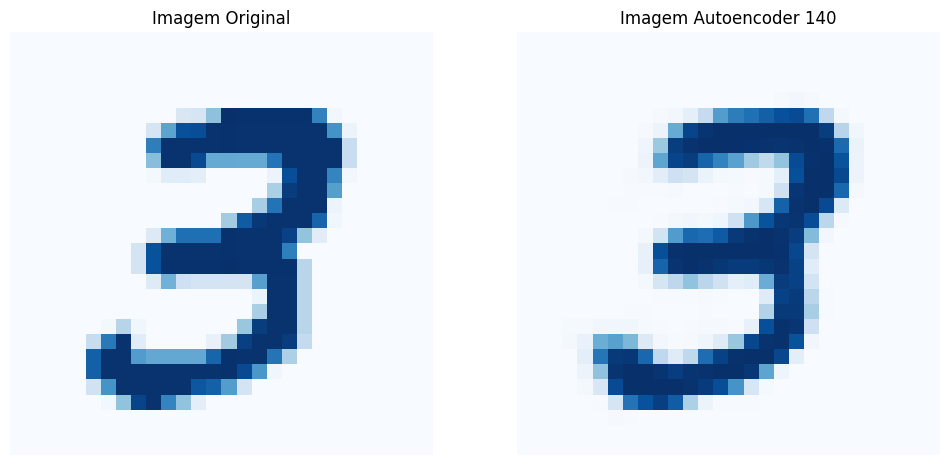

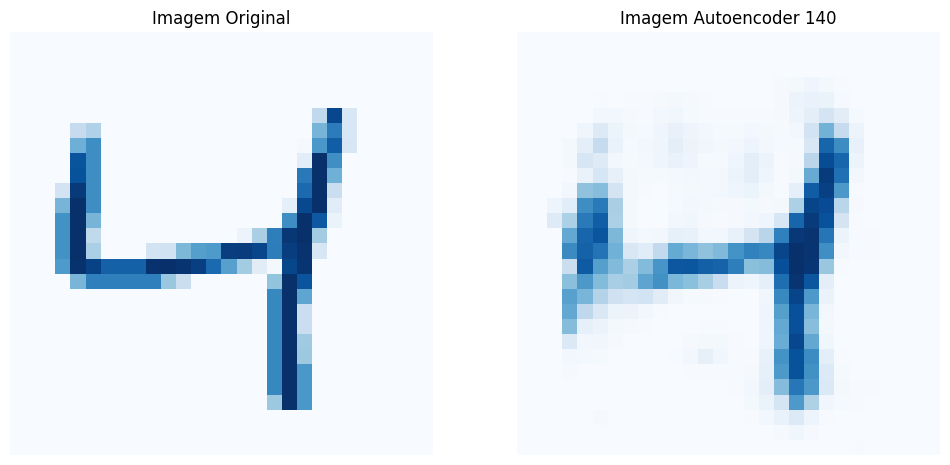

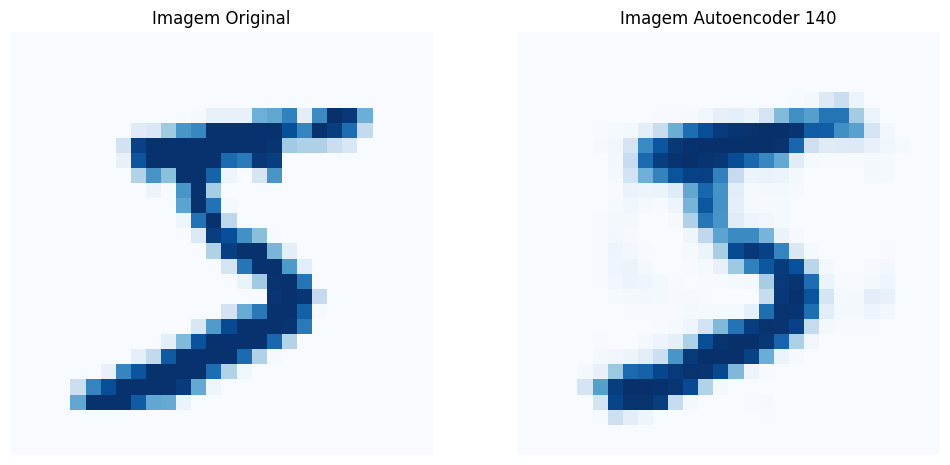

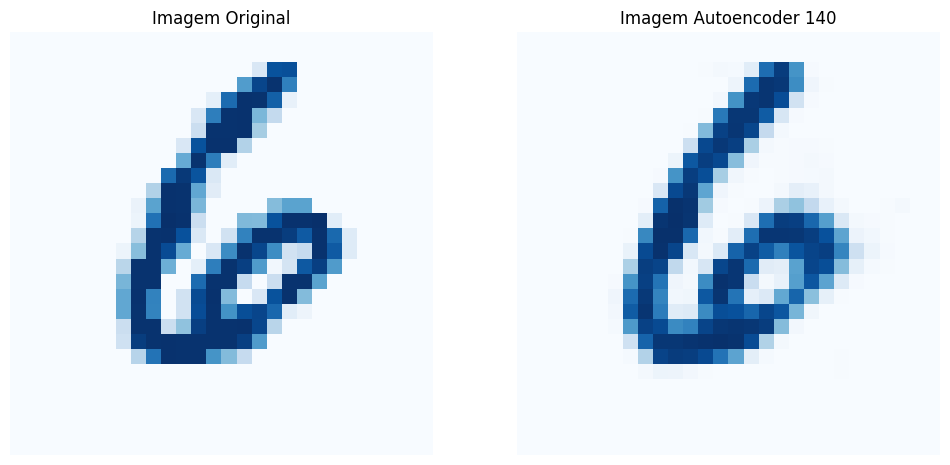

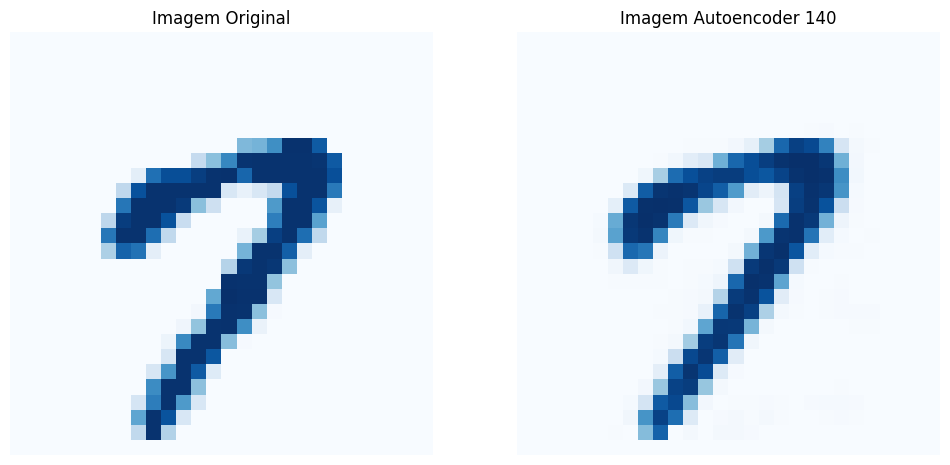

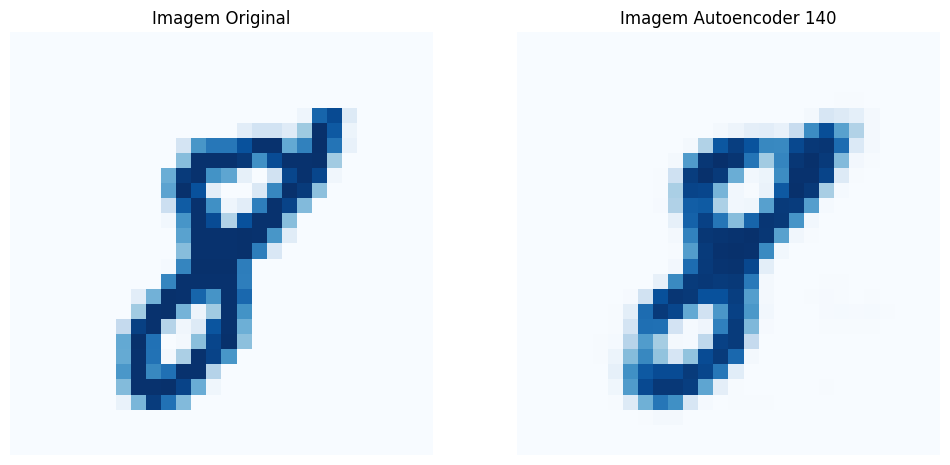

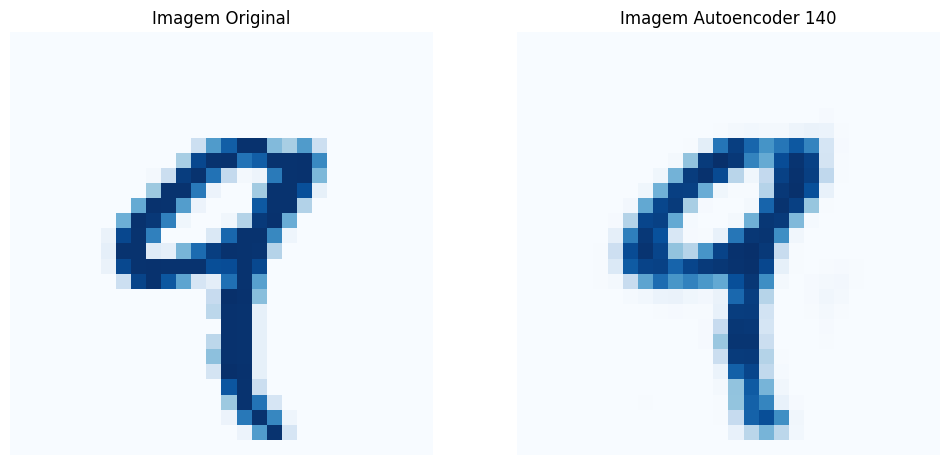

In [7]:
image_0 = ToPILImage()(train_dataset[1][0])
image_1 = ToPILImage()(train_dataset[3][0])
image_2 = ToPILImage()(train_dataset[5][0])
image_3 = ToPILImage()(train_dataset[7][0])
image_4 = ToPILImage()(train_dataset[2][0])
image_5 = ToPILImage()(train_dataset[0][0])
image_6 = ToPILImage()(train_dataset[13][0])
image_7 = ToPILImage()(train_dataset[15][0])
image_8 = ToPILImage()(train_dataset[17][0])
image_9 = ToPILImage()(train_dataset[4][0])

with torch.no_grad():
    modelo.eval()
    image_ae_0 = ToPILImage()(modelo(train_dataset[1][0]).view(1,28,28))
    image_ae_1 = ToPILImage()(modelo(train_dataset[3][0]).view(1,28,28))
    image_ae_2 = ToPILImage()(modelo(train_dataset[5][0]).view(1,28,28))
    image_ae_3 = ToPILImage()(modelo(train_dataset[7][0]).view(1,28,28))
    image_ae_4 = ToPILImage()(modelo(train_dataset[2][0]).view(1,28,28))
    image_ae_5 = ToPILImage()(modelo(train_dataset[0][0]).view(1,28,28))
    image_ae_6 = ToPILImage()(modelo(train_dataset[13][0]).view(1,28,28))
    image_ae_7 = ToPILImage()(modelo(train_dataset[15][0]).view(1,28,28))
    image_ae_8 = ToPILImage()(modelo(train_dataset[17][0]).view(1,28,28))
    image_ae_9 = ToPILImage()(modelo(train_dataset[4][0]).view(1,28,28))
for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))  

    axes[0].imshow(globals()[f'image_{i}'], cmap='Blues')  
    axes[0].set_title('Imagem Original')  
    axes[0].axis('off') 

    axes[1].imshow(globals()[f'image_ae_{i}'], cmap='Blues')  
    axes[1].set_title('Imagem Autoencoder 140') 
    axes[1].axis('off') 

    plt.show()

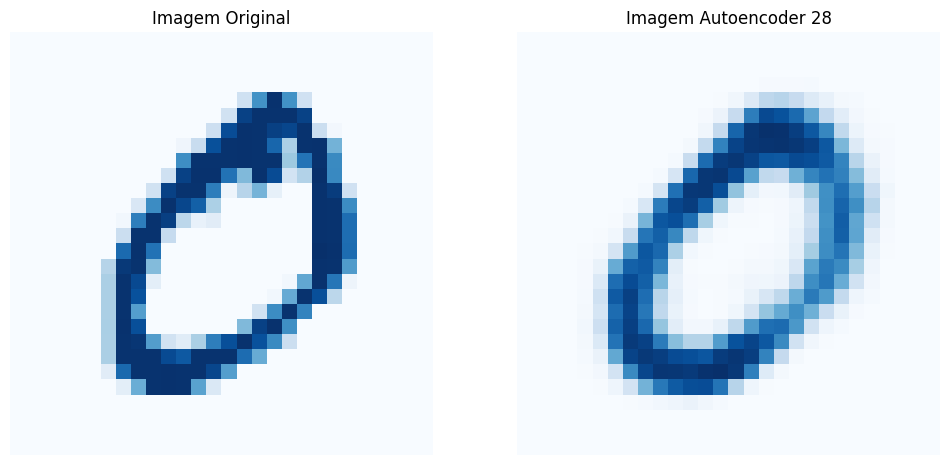

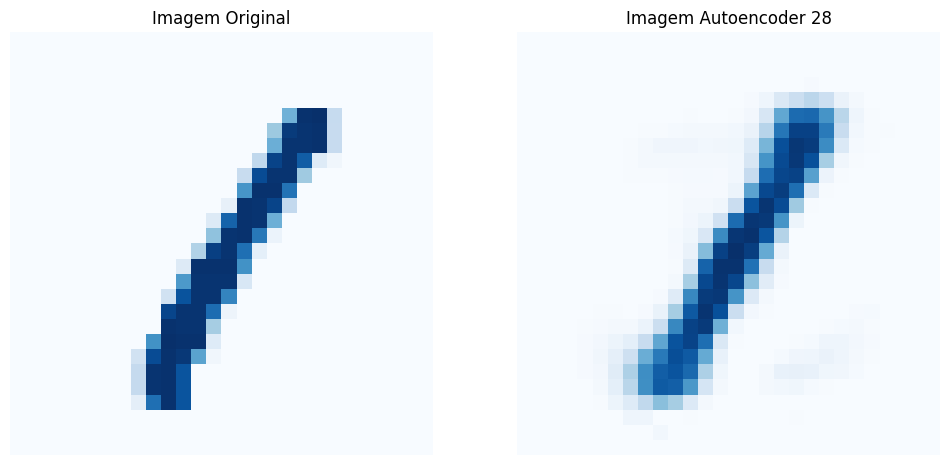

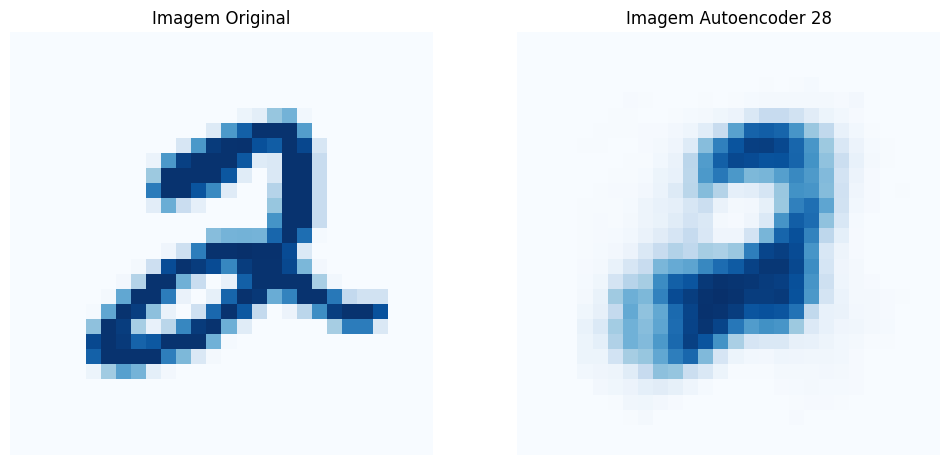

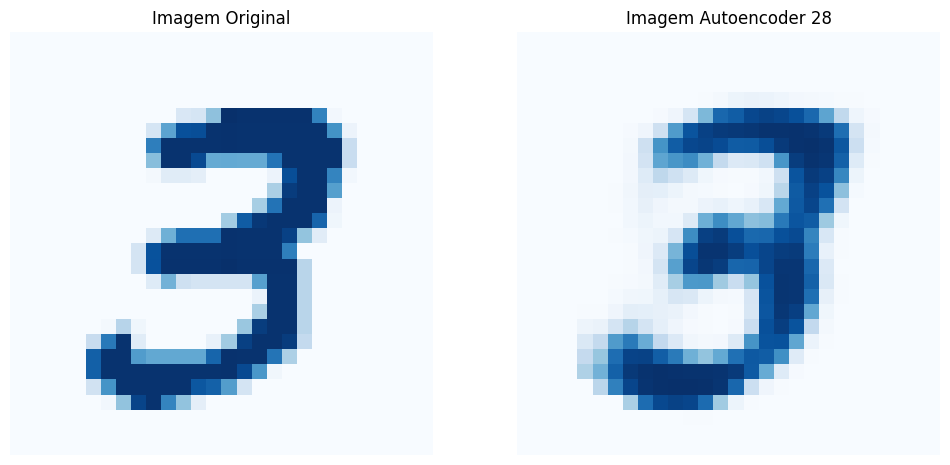

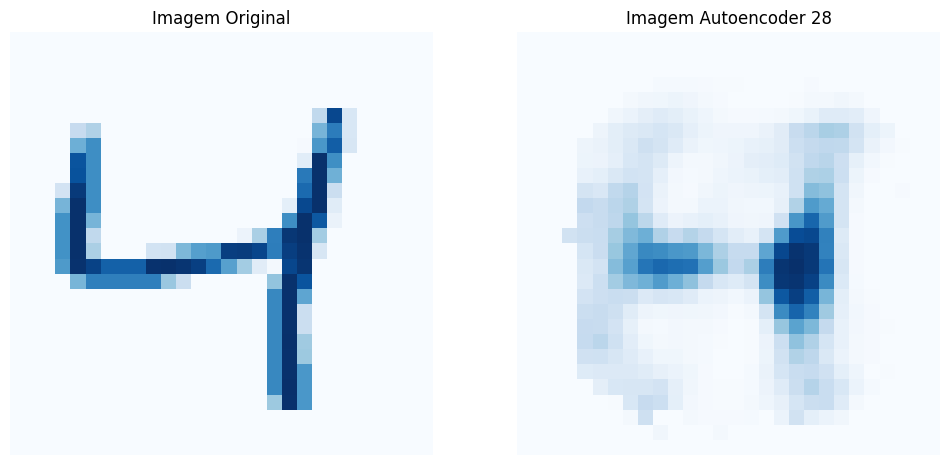

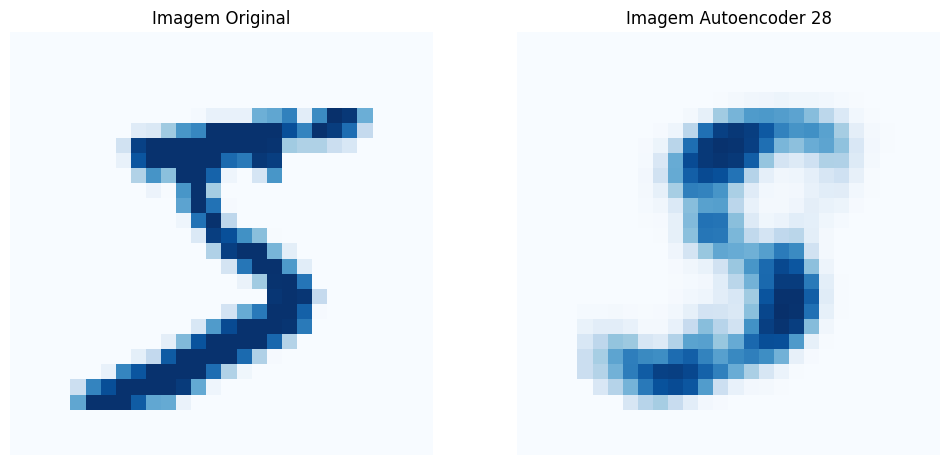

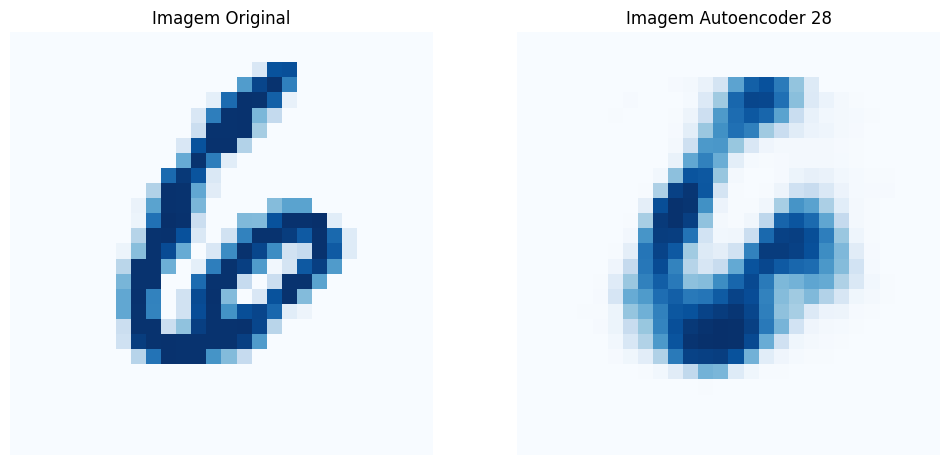

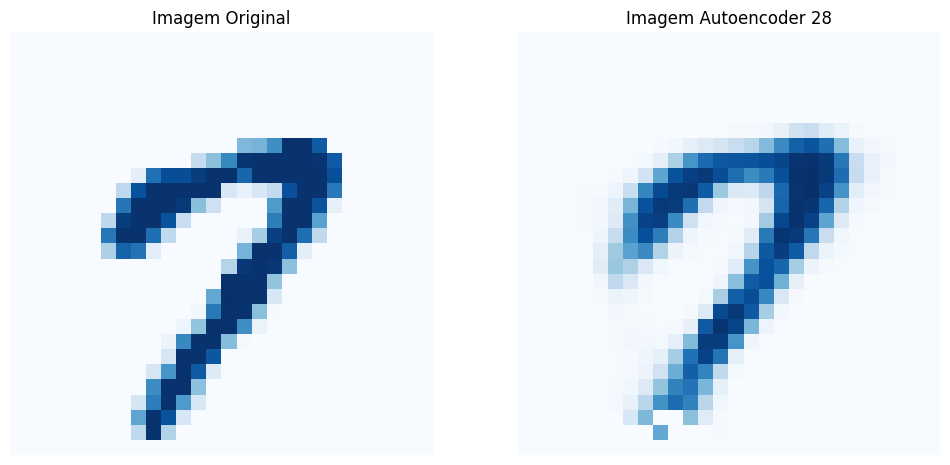

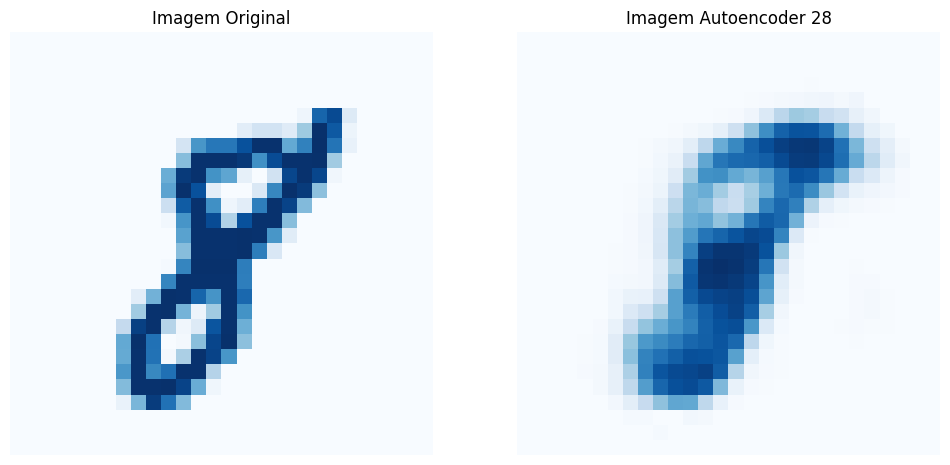

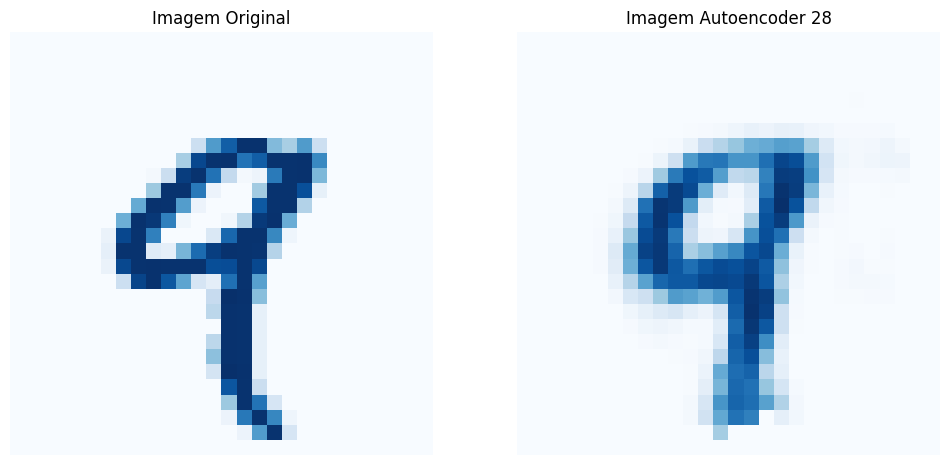

In [8]:
with torch.no_grad():
    modelo.eval()
    image_ae_0_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[1][0]).view(1,28,28))
    image_ae_1_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[3][0]).view(1,28,28))
    image_ae_2_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[5][0]).view(1,28,28))
    image_ae_3_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[7][0]).view(1,28,28))
    image_ae_4_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[2][0]).view(1,28,28))
    image_ae_5_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[0][0]).view(1,28,28))
    image_ae_6_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[13][0]).view(1,28,28))
    image_ae_7_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[15][0]).view(1,28,28))
    image_ae_8_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[17][0]).view(1,28,28))
    image_ae_9_ = ToPILImage()(modelo_bottle_reduzido(train_dataset[4][0]).view(1,28,28))

for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))  

    axes[0].imshow(globals()[f'image_{i}'], cmap='Blues')  
    axes[0].set_title('Imagem Original')  
    axes[0].axis('off') 

    axes[1].imshow(globals()[f'image_ae_{i}_'], cmap='Blues')  
    axes[1].set_title('Imagem Autoencoder 28') 
    axes[1].axis('off') 

    plt.show()

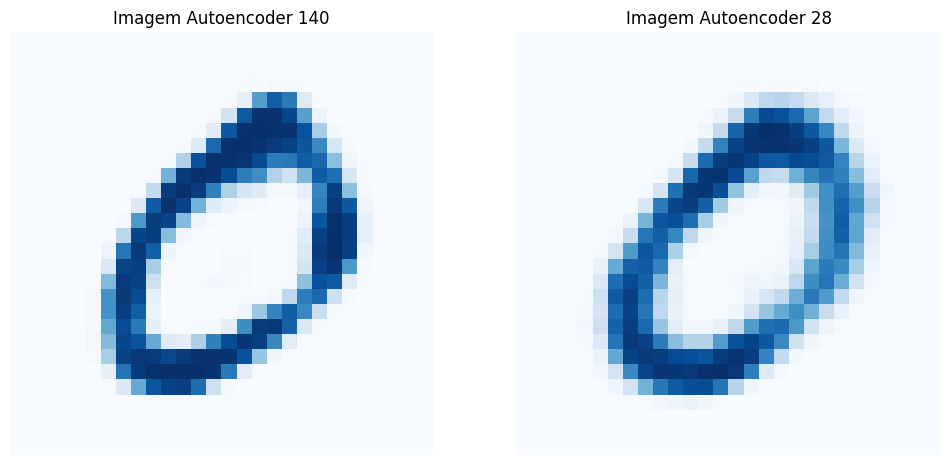

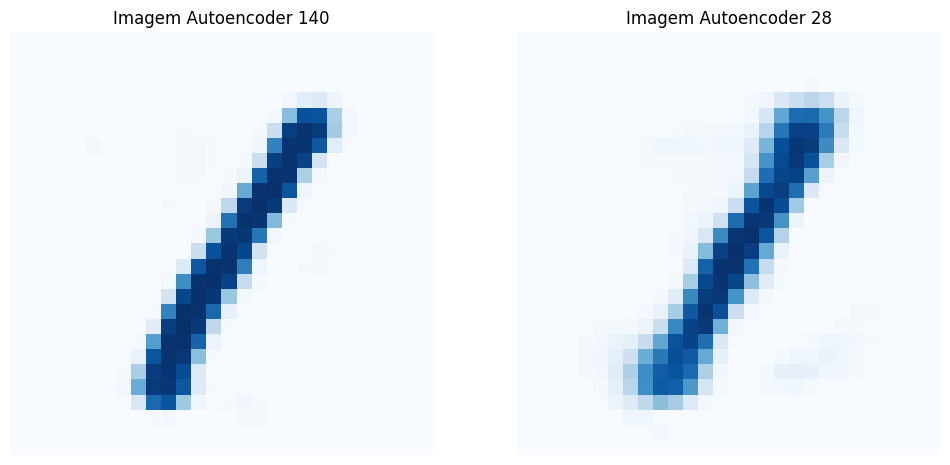

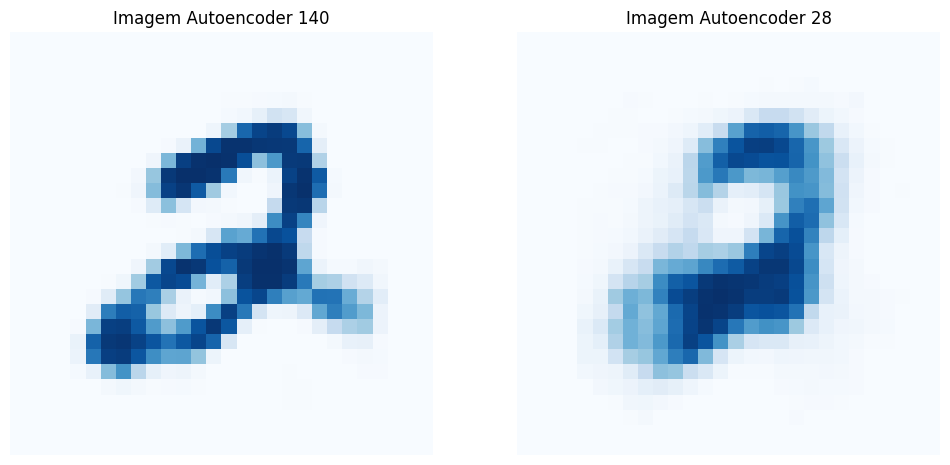

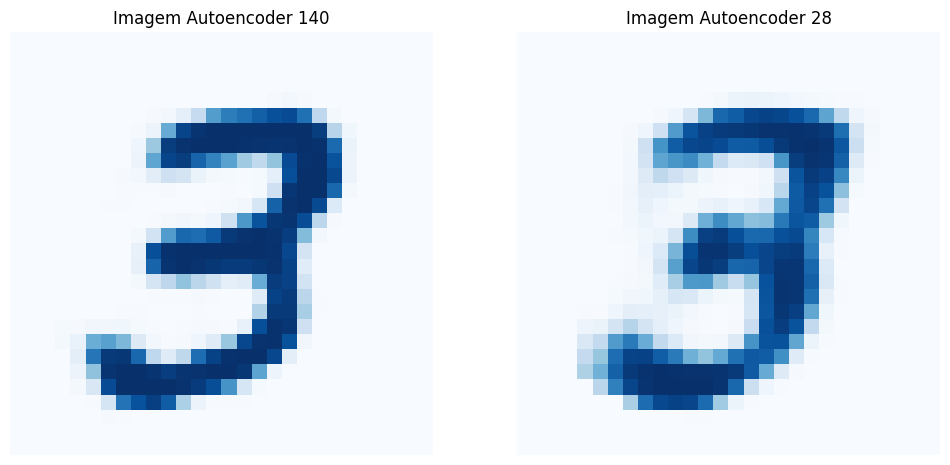

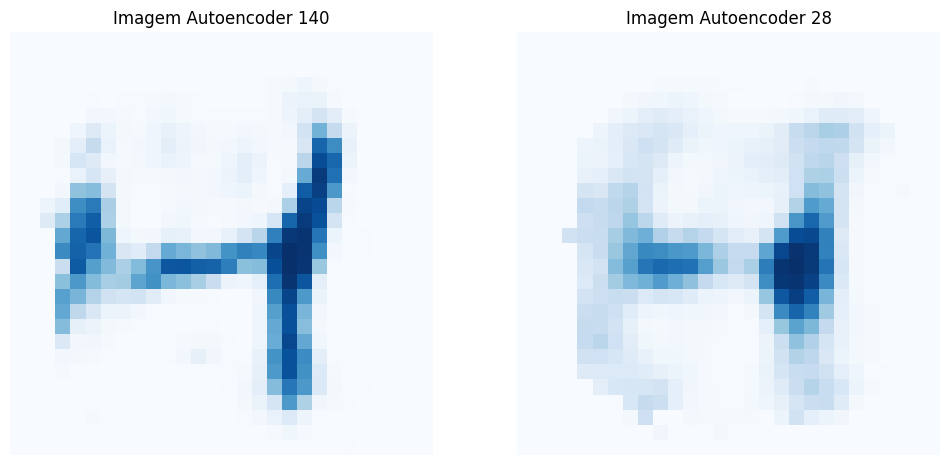

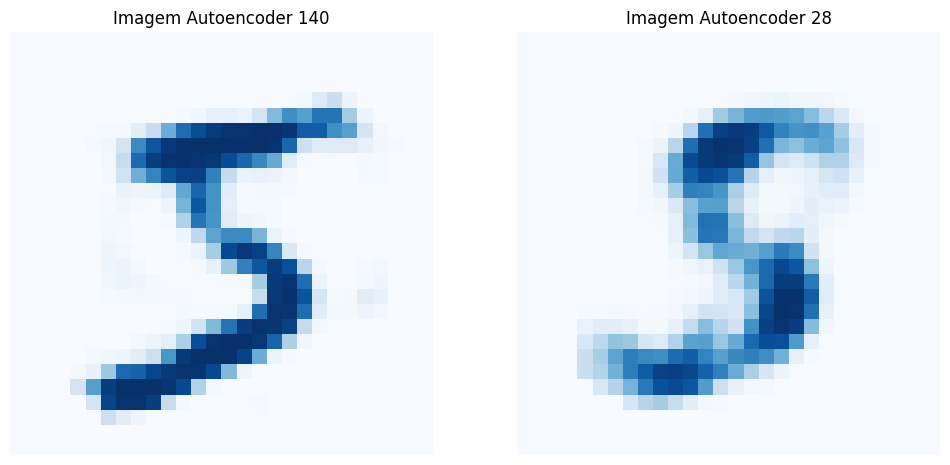

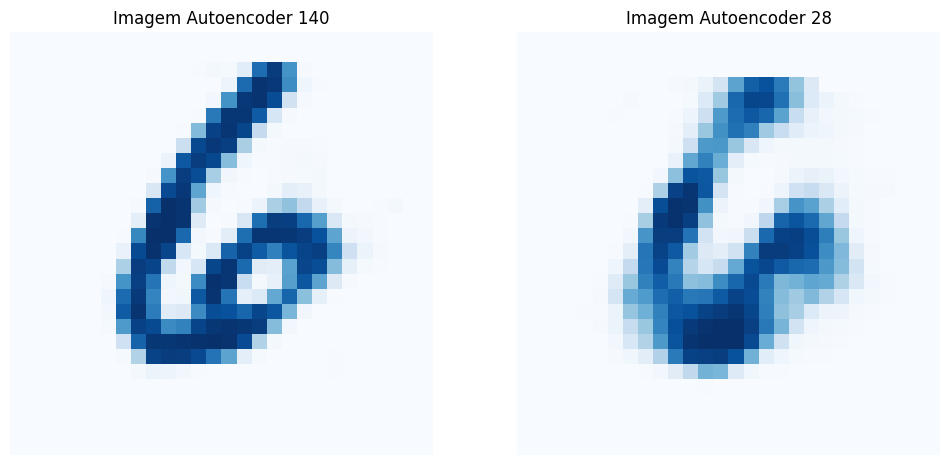

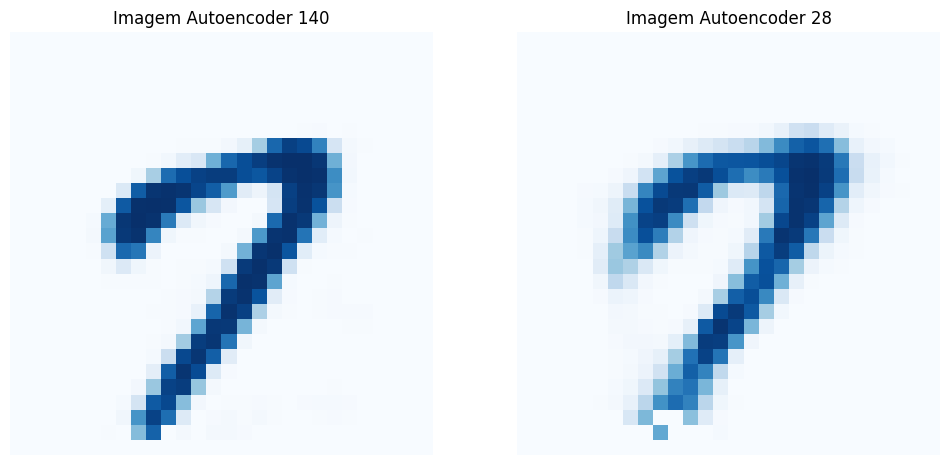

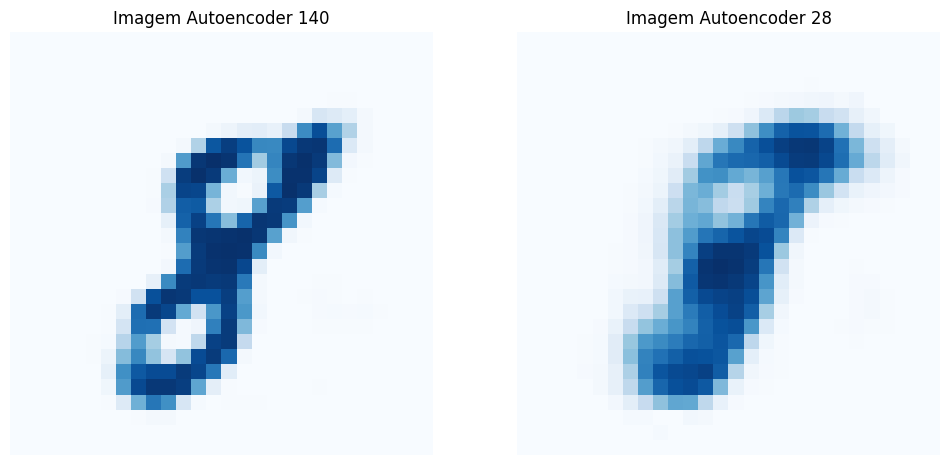

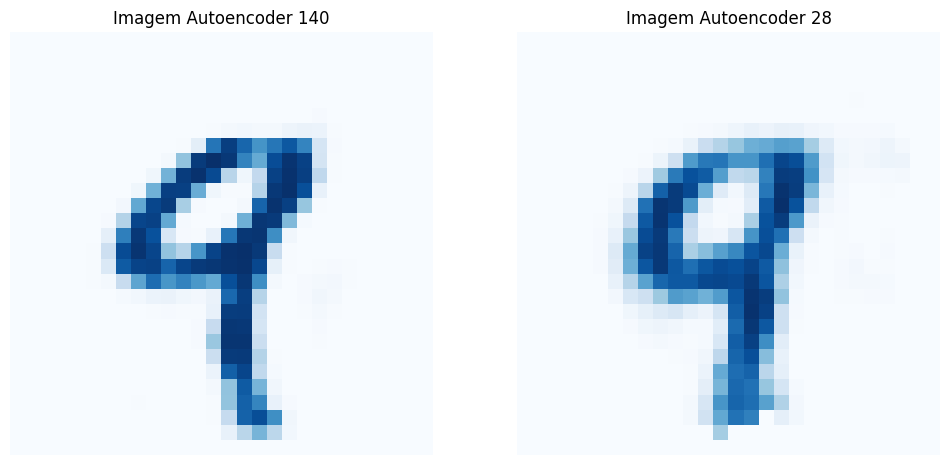

In [9]:
for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))  

    axes[0].imshow(globals()[f'image_ae_{i}'], cmap='Blues')  
    axes[0].set_title('Imagem Autoencoder 140')  
    axes[0].axis('off') 

    axes[1].imshow(globals()[f'image_ae_{i}_'], cmap='Blues')  
    axes[1].set_title('Imagem Autoencoder 28') 
    axes[1].axis('off') 

    plt.show()

In [10]:
image_ae02 = ToPILImage()(modelo_bottle_reduzido(train_dataset[21][0]).view(1,28,28))
image_ae12= ToPILImage()(modelo_bottle_reduzido(train_dataset[23][0]).view(1,28,28))
image_ae22 = ToPILImage()(modelo_bottle_reduzido(train_dataset[25][0]).view(1,28,28))
image_ae32 = ToPILImage()(modelo_bottle_reduzido(train_dataset[27][0]).view(1,28,28))
image_ae42 = ToPILImage()(modelo_bottle_reduzido(train_dataset[20][0]).view(1,28,28))
image_ae52 = ToPILImage()(modelo_bottle_reduzido(train_dataset[35][0]).view(1,28,28))
image_ae62 = ToPILImage()(modelo_bottle_reduzido(train_dataset[38][0]).view(1,28,28))
image_ae72 = ToPILImage()(modelo_bottle_reduzido(train_dataset[15][0]).view(1,28,28))
image_ae82 = ToPILImage()(modelo_bottle_reduzido(train_dataset[31][0]).view(1,28,28))
image_ae92 = ToPILImage()(modelo_bottle_reduzido(train_dataset[19][0]).view(1,28,28))

In [11]:
image_ae_0_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[21][0]).view(1,28,28))
image_ae_1_2= ToPILImage()(modelo_bottle_reduzido(train_dataset[23][0]).view(1,28,28))
image_ae_2_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[25][0]).view(1,28,28))
image_ae_3_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[27][0]).view(1,28,28))
image_ae_4_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[20][0]).view(1,28,28))
image_ae_5_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[35][0]).view(1,28,28))
image_ae_6_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[38][0]).view(1,28,28))
image_ae_7_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[15][0]).view(1,28,28))
image_ae_8_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[31][0]).view(1,28,28))
image_ae_9_2 = ToPILImage()(modelo_bottle_reduzido(train_dataset[19][0]).view(1,28,28))

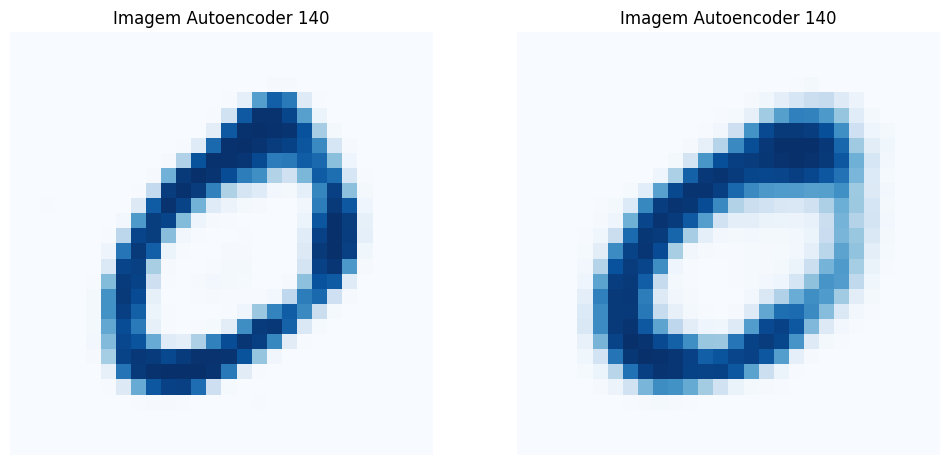

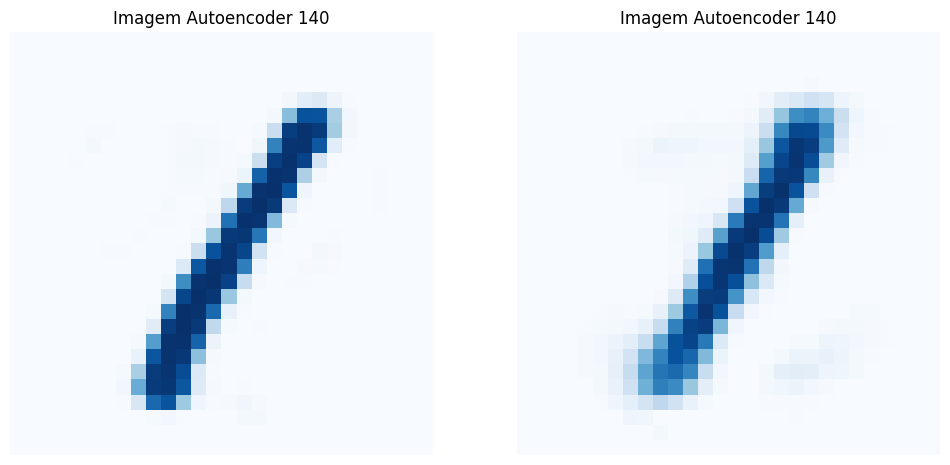

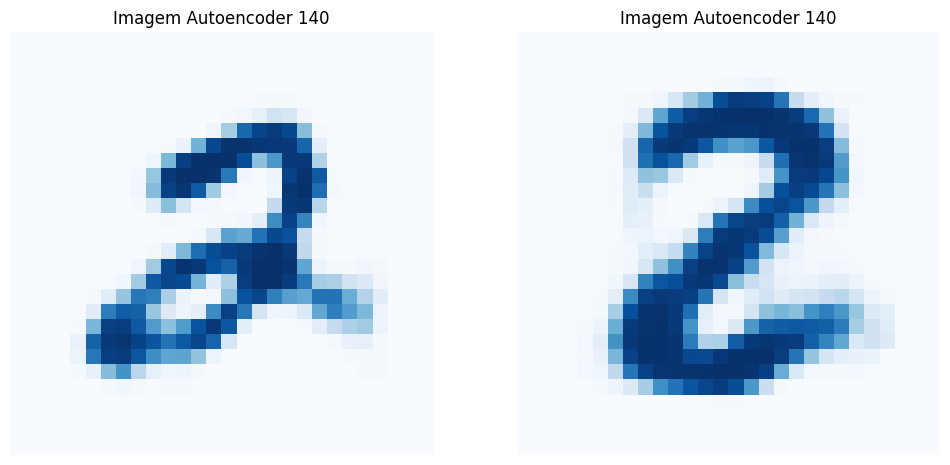

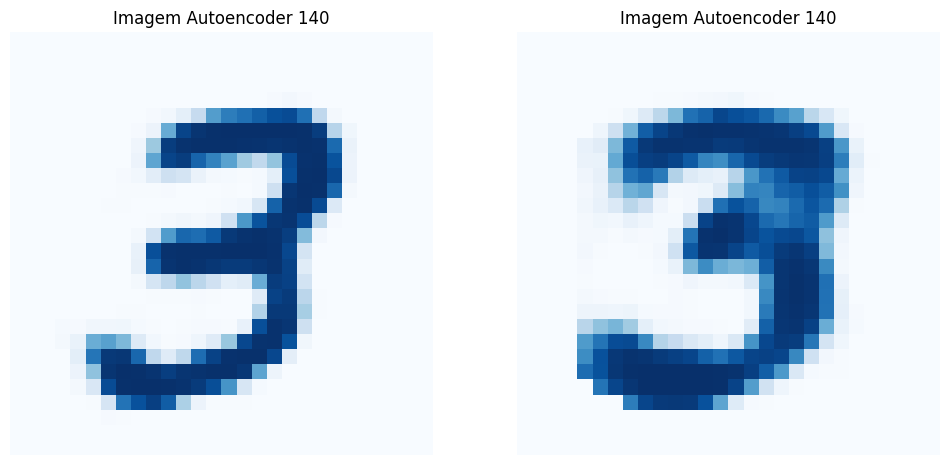

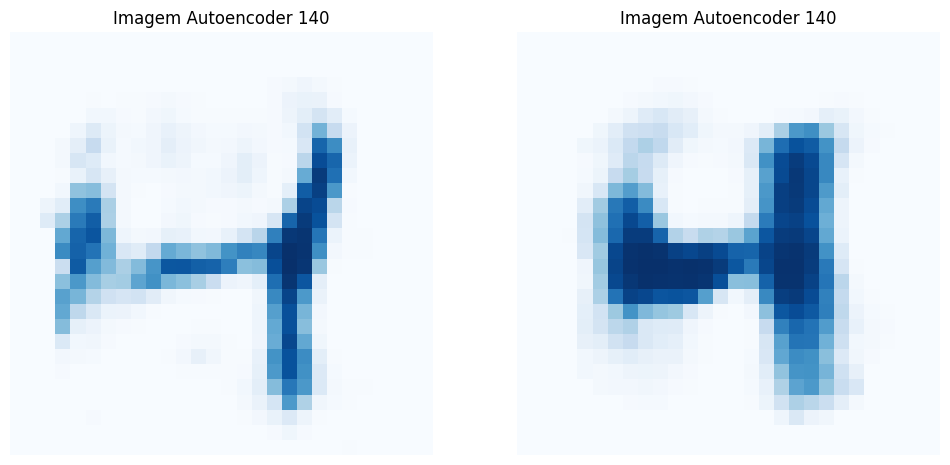

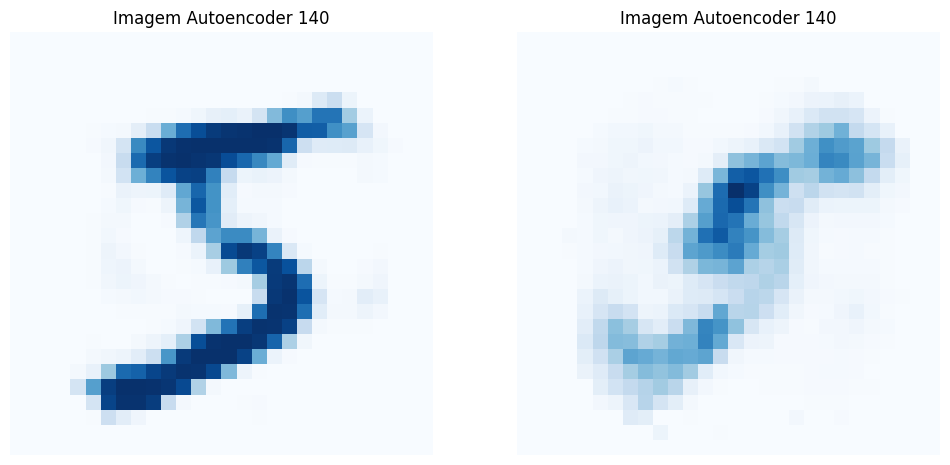

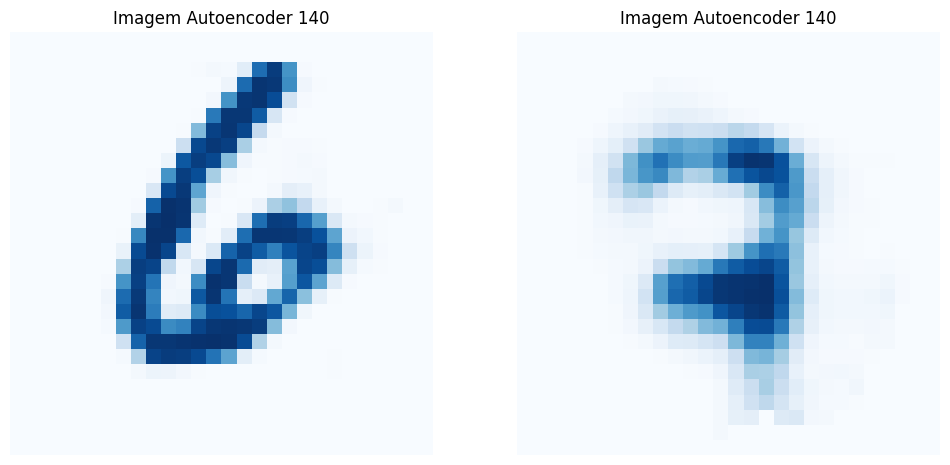

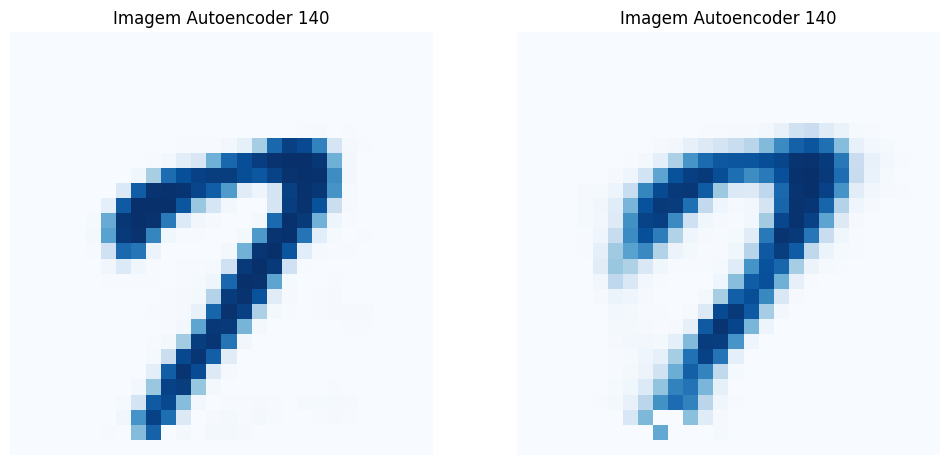

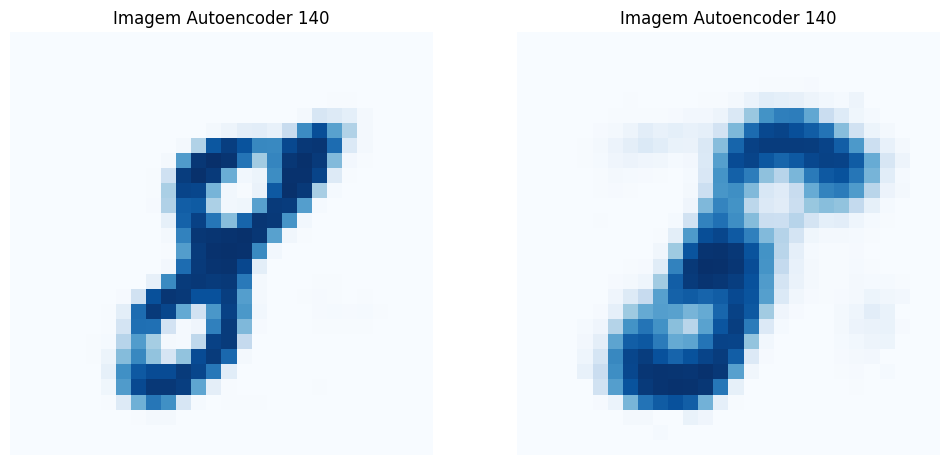

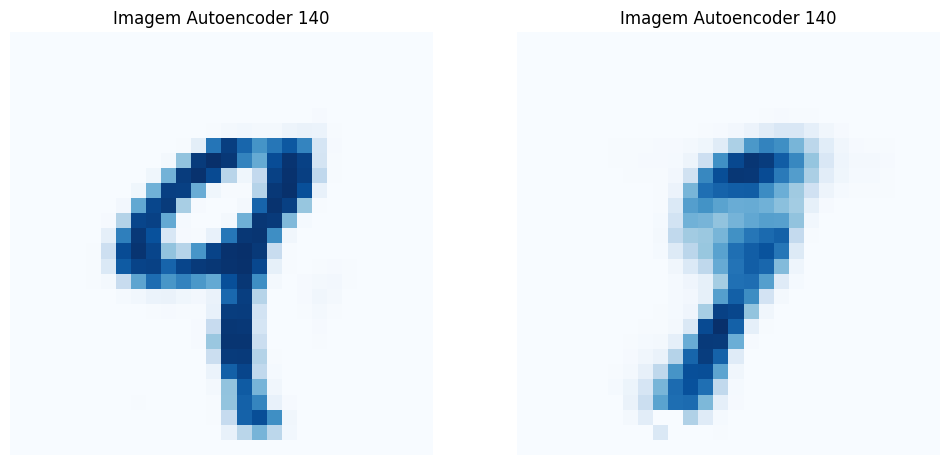

In [12]:
for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))  

    axes[0].imshow(globals()[f'image_ae_{i}'], cmap='Blues')  
    axes[0].set_title('Imagem Autoencoder 140')  
    axes[0].axis('off') 

    axes[1].imshow(globals()[f'image_ae{i}2'], cmap='Blues')  
    axes[1].set_title('Imagem Autoencoder 140') 
    axes[1].axis('off') 

    plt.show()

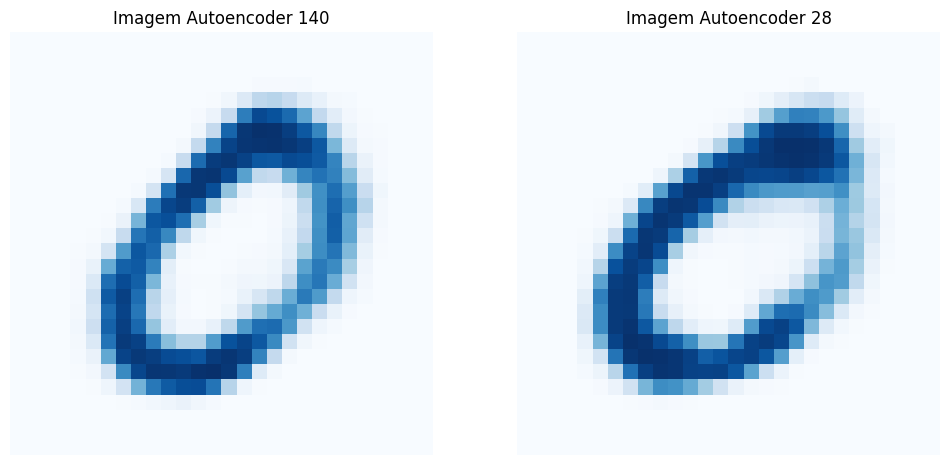

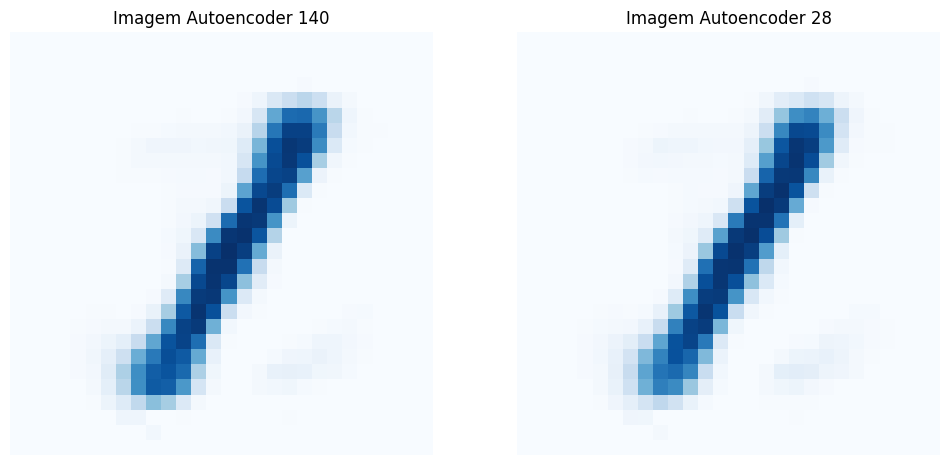

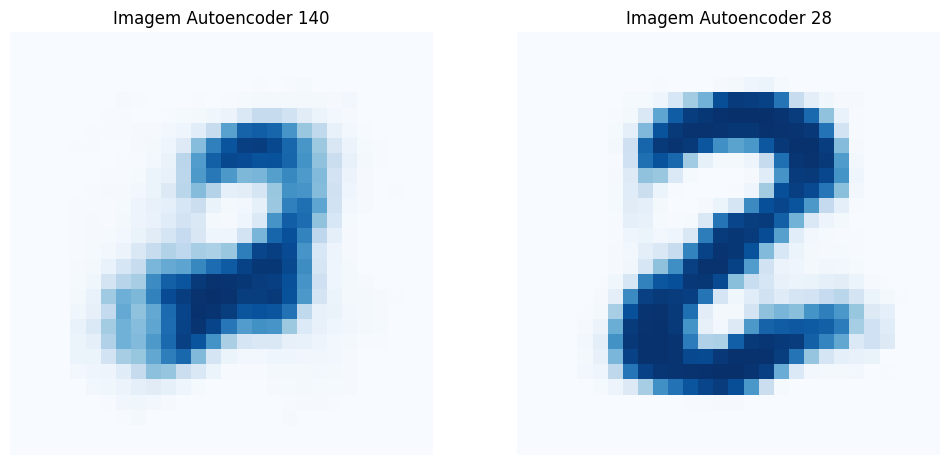

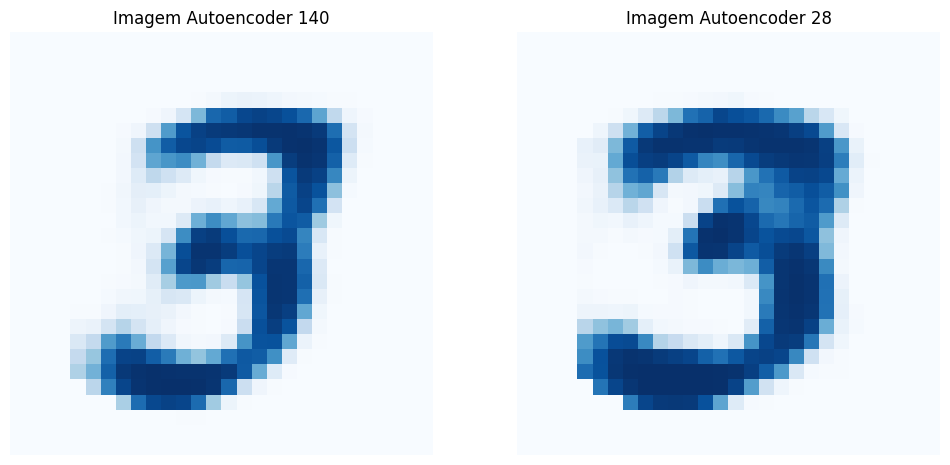

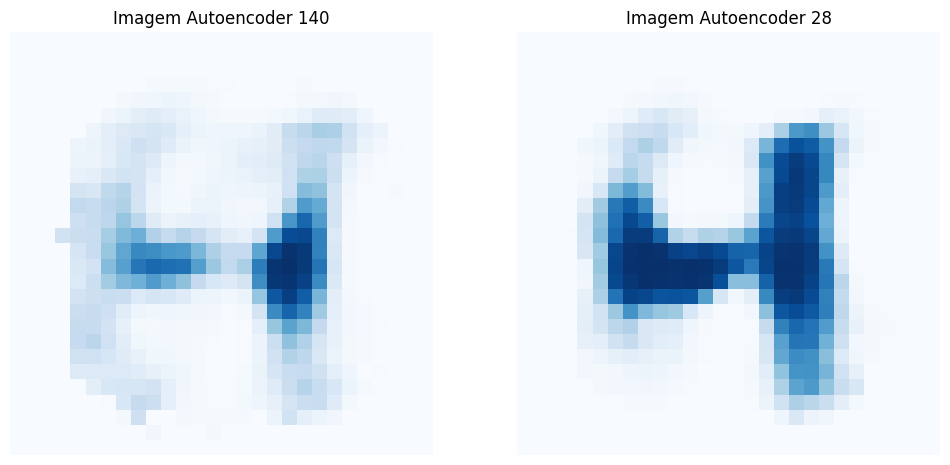

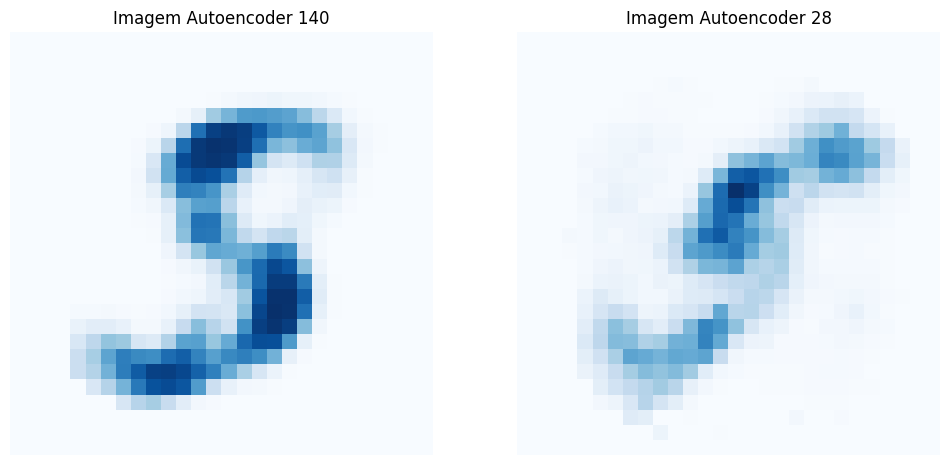

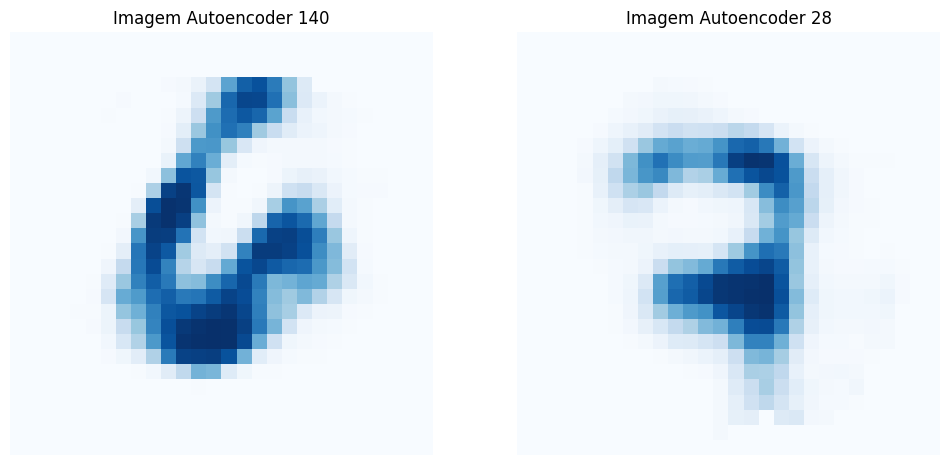

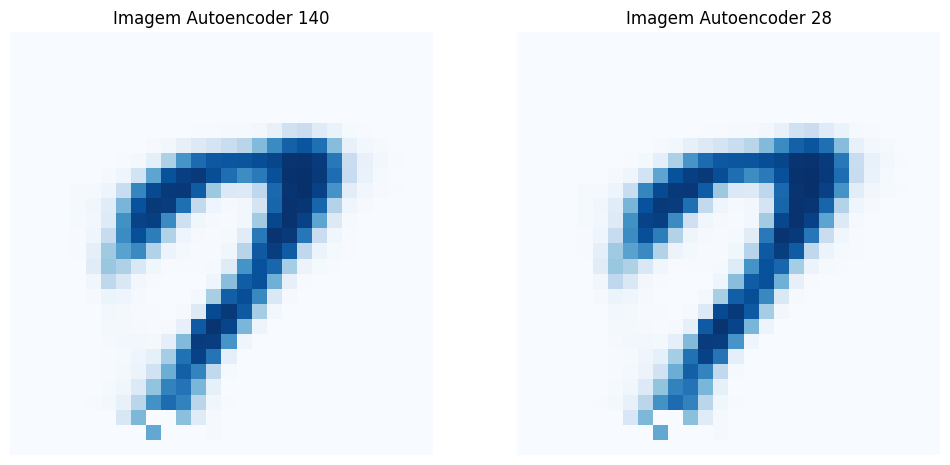

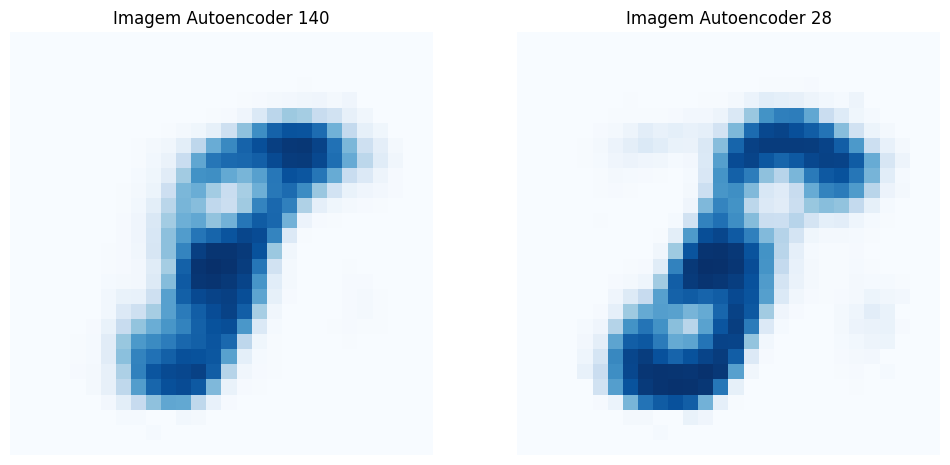

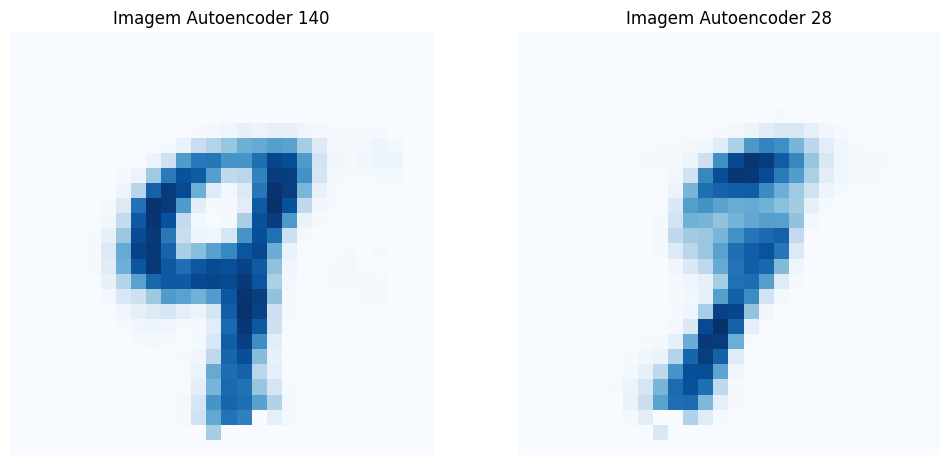

In [13]:
for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))  

    axes[0].imshow(globals()[f'image_ae_{i}_'], cmap='Blues')  
    axes[0].set_title('Imagem Autoencoder 140')  
    axes[0].axis('off') 

    axes[1].imshow(globals()[f'image_ae_{i}_2'], cmap='Blues')  
    axes[1].set_title('Imagem Autoencoder 28') 
    axes[1].axis('off') 

    plt.show()

#### Conclusão:
Podemos perceber que o Autoencoder é um modelo que serve para redução do tamanho dos dados de entrada, o que numa rede bem treinada leva à permanência dos dados mais importantes. Estes dados também podem ser reconstruídos no Decoder, quanto maior a redução, mais difícil é do decoder reconstruir com semelhaça aos dados originais. Os Autoencoders parecem então ser úteis para compactação, redução de ruído e filtragem de dados.

### Referências
- Deep Learning With PyTorch. Playlist de vídeos sobre CNN. Disponível em: http://www.youtube.com/playlist?list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1
- Classes da MLP em Python puro. Obtidos em: ATP-303 NN 4.2 - Notebook MLP.ipynb